# Projeto de Simulação - Algotrading
### Vinícius Matheus Morales
___
## Introdução
O estudo realizado nesse projeto tem como tema mesclar três indicadores técnicos para a tomada de decisão de compra ou venda de um determinado ativo.
___

## Metodologia
Os indicadores que serão utilizados para tal serão:
- Bollinger Bands https://en.wikipedia.org/wiki/Bollinger_Bands
- KST Oscillator https://en.wikipedia.org/wiki/KST_oscillator
- Parabolic SAR https://en.wikipedia.org/wiki/Parabolic_SAR

### Bollinger Bands
Calcula-se um range em torno da média móvel com base em uma quantidade *m* de desvios padrão da média de um período *n*.

$$ Upper band = avg(p, n) + m * std(p, n) $$
$$ Lower band = avg(p, n) - m * std(p, n) $$

Pode ser interpretado de diversas maneiras, tais como:
1. Comprar quando o preço tocar a banda inferior e vender quando tocar a banda superior.
2. Comprar quando o preço tocar a banda superior e vender quando tocar a banda inferior.
3. Comprar quando o preço tocar a banda inferior e zerar posição quando tocar a média móvel.
4. Utilizar um *m* baixo e um *n* rápido para atuar como *trend follower*.
5. etc.

Nesse projeto será usado como *trend follower*
___
### Know Sure Thing Oscillator (KST)
Primeiro calcula-se quatro taxas de variação suavizadas com tendo como base *X1*, *X2*, *X3* e *X4* dias, semanas ou meses anteriores.
$$ ROC1 = (Price/Price(X1) - 1) * 100 $$
$$ ROC2 = (Price/Price(X2) - 1) * 100 $$
$$ ROC3 = (Price/Price(X3) - 1) * 100 $$
$$ ROC4 = (Price/Price(X4) - 1) * 100 $$

Sendo *X1*, *X2*, *X3* e *X4* iguais à, respectivamente:
- 10, 15, 20, 30 (dias)
- 10, 13, 15, 20 (semanas)
- 9, 12, 18, 24 (meses)

Então suaviza as taxas de variação, respectivamente, seguindo padrões recomendados por Martin J Pring (criador do indicador) com base em médias móveis simples, nomeadas de *AVG1*, *AVG2*, *AVG3* e *AVG4*, com valores:
- 10, 10, 10, 15 (dias)
- 10, 13, 15, 20 (semanas)
- 6, 6, 6, 9 (meses)

Tendo também, como padrão, os pesos *W1*, *W2*, *W3* e *W4*, respectivamente:
$$ W1 = 1 $$
$$ W2 = 2 $$
$$ W3 = 3 $$
$$ W4 = 4 $$

Ficando então como fórmula final:
$$ KST = MOV(ROC1, AVG1) * W1 + MOV(ROC2, AVG2) * W2 + MOV(ROC3, AVG3) * W3 + MOV(ROC4, AVG4) * W4 $$

Sendo que MOV(ROC, AVG) é a média móvel simples do período *AVG* de taxa de variação *ROC*

Por fim, se compara os cruzamentos com a média móvel simples de 9 dias, semanas ou meses.

A tomada de decisão se baseia em:
1. Comprar quando KST cruzar vindo por baixo da média móvel de 9 dias, semanas ou meses.
2. Vender quando KST cruzar vindo por cima da média móvel de 9 dias, semanas ou meses.
___
### Parabolic Stop And Reverse (PSAR)

## Resultado esperado
Ao mesclar esses indicadores é esperado que 

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_ta as ta
import time, datetime, random
from dateutil.relativedelta import relativedelta

# Para fazer o backtesting
from backtesting import evaluateHist, evaluateIntr, Strategy, Order

In [2]:
# O scrape desses dados não estava dando certo
tickers = 'AMD AMC AAPL NIO DIDI PATH BAC ITUB NVDA F TLRY CCL INTC T TELL SWN MU MSFT SOFI OXY DNA AAL VZ PBR BABA PBR VALE IQ C XOM CSCO HOOD PFE ET BBD KMI FB HPQ BCS ABEV NLY WBA PLTR CMCSA KOS NCLH TME UBER FLEX MRO PLUG PDD NOK SIRI PBCT JPM GM BMY GRAB KO RIG NLSN TSLA BEKE FCEL LCID KGC PBR-A SNAP LAC NAVI DKNG CLF RLX PYPL JD RBLX M SQ SPCE BP QCOM UMC CX CCJ TSM VTRS HST SCHW RIVN AUY MRK DIS AFRM BB X CSX UAL ZNGA SLB GOLD JNJ DVN SBUX TWTR CVE VIPS HD NKLA RF BKR FCX V BILI IBN HBAN HPE CVX TJX TEVA LU BSX NEE PINS CHPT PLAN DAL FUTU COP PTON OPEN USB FTI CDEV ORCL AGNC EBAY UPST XPEV HAL STNE CTRA WMT WMB KEY BTG GME GGB LUMN CS ABBV PCG DISCA CVS KR AMAT COTY MS EQT LI ING MDLZ IVZ GILD GE MARA QS AR MRVL SHO GPS MOS BIDU APA CHWY INFY TPX DHI CL AMCR FITB CPG PG ARVI TFC CNHI CGC FHN LYG LOW JBLU MNDT PARA NKE TXN CRM NEM MPC MO MDT NRZ BTU RRC ERIC SU Z CNP MTTR DELL BA SMFG NYCB HL SID RYCEY ON EXC GFI AZN BBWI ASX BRK-B PEP RIOT FRGE PPL MQ SE BK WE VICI SYF UAA AEO SO MRNA JNPR VRT RTX EQNR IS KIM RCL ABT CPNG VLO SABR SLM CG SLM CIG TECK GLW PAA KHC EPD'
tickers = tickers.split() # Transformando em lista
tickers = list(set(tickers)) # Removendo duplicados

# Escolher aleatoriamente 3 tickers
ticker1 = random.choice(tickers)
tickers.remove(ticker1)

ticker2 = random.choice(tickers)
tickers.remove(ticker2)

ticker3 = random.choice(tickers)
tickers.remove(ticker3)

sel_tickers = [ticker1, ticker2, ticker3]

print(f'Os tickers escolhidos foram: {ticker1}, {ticker2} e {ticker3}')

Os tickers escolhidos foram: GE, IBN e SIRI


In [3]:
# Bloco para gerar um dia útil aleatório entre 5 a 10 anos atrás

# Função para conferir se o dia dado é útil
is_bday = lambda date: bool(len(pd.bdate_range(date, date)))

# Dia útil mais próximo de hoje
today = datetime.date.today()
while not is_bday(today):
    today -= datetime.timedelta(days=1)

# Enquanto não for um dia útil, gerar novamente um ano aleatório
start_date = today - relativedelta(years=random.choice([5, 6, 7, 8, 9, 10]))
while not is_bday(start_date):
    start_date -= datetime.timedelta(days=1)
    
print(f'O dia útil no qual iniciará o teste é: {start_date.strftime("%d/%m/%Y")}')
print(f'O dia útil mais próximo de hoje é: {today.strftime("%d/%m/%Y")}')

today = str(today)
start_date = str(start_date)

O dia útil no qual iniciará o teste é: 07/04/2014
O dia útil mais próximo de hoje é: 07/04/2022


In [4]:
import yahoofinancials as yf
for ticker in sel_tickers:
    data = yf.YahooFinancials(ticker).get_historical_price_data(start_date, today, 'daily')

    # Ler os dados do JSON
    raw = pd.DataFrame(data[ticker]['prices']).dropna()
    # Converter a data para o tipo correto datetime
    raw['formatted_date'] = pd.to_datetime(raw['formatted_date'])
    # Indica a data como o índice de cada linha
    raw = raw.set_index('formatted_date')
    # Removendo as colunas que não interessam
    df = raw.iloc[:,1:]

    # Acertando a ordem das colunas
    df = df.reindex(columns=['open', 'high', 'low', 'close', 'adjclose', 'volume'])
    # Salvando o CSV
    df.to_csv(f'{ticker}.csv')

In [5]:
df1 = pd.read_csv(f'{ticker1}.csv')
df1.head()

,formatted_date,open,high,low,close,adjclose,volume
0,2014-04-07,199.615387,200.307693,198.000000,198.846161,167.575623,3957057
1,2014-04-08,198.153839,199.384613,197.461533,198.076920,166.927383,3499067
2,2014-04-09,198.923080,199.692307,196.846161,199.615387,168.223892,3273075
3,2014-04-10,200.692307,200.846161,196.692307,196.769226,165.825363,4718181
4,2014-04-11,196.230774,198.153839,195.615387,195.615387,164.852951,4851587


In [6]:
df2 = pd.read_csv(f'{ticker2}.csv')
df2.head()

,formatted_date,open,high,low,close,adjclose,volume
0,2014-04-07,7.754545,7.869091,7.729091,7.765455,7.199932,6157800
1,2014-04-08,7.849091,7.918182,7.798182,7.901818,7.326363,6639600
2,2014-04-09,8.076364,8.145455,8.003636,8.141818,7.548885,14353900
3,2014-04-10,8.096364,8.105455,7.830909,7.832727,7.262304,6371200
4,2014-04-11,7.827273,7.925455,7.752727,7.760000,7.194874,7436550


In [7]:
df3 = pd.read_csv(f'{ticker3}.csv')
df3.head()

,formatted_date,open,high,low,close,adjclose,volume
0,2014-04-07,3.20,3.21,3.11,3.12,2.874014,81414300
1,2014-04-08,3.14,3.15,3.06,3.07,2.827956,137591800
2,2014-04-09,3.08,3.16,3.08,3.14,2.892438,147610200
3,2014-04-10,3.13,3.18,3.05,3.10,2.855592,123069900
4,2014-04-11,3.13,3.24,3.10,3.16,2.910861,89953700


In [8]:
help(ta.bbands)

Help on function bbands in module pandas_ta.volatility.bbands:

bbands(close, length=None, std=None, ddof=0, mamode=None, talib=None, offset=None, **kwargs)
    Bollinger Bands (BBANDS)
    
    A popular volatility indicator by John Bollinger.
    
    Sources:
        https://www.tradingview.com/wiki/Bollinger_Bands_(BB)
    
    Calculation:
        Default Inputs:
            length=5, std=2, mamode="sma", ddof=0
        EMA = Exponential Moving Average
        SMA = Simple Moving Average
        STDEV = Standard Deviation
        stdev = STDEV(close, length, ddof)
        if "ema":
            MID = EMA(close, length)
        else:
            MID = SMA(close, length)
    
        LOWER = MID - std * stdev
        UPPER = MID + std * stdev
    
        BANDWIDTH = 100 * (UPPER - LOWER) / MID
        PERCENT = (close - LOWER) / (UPPER - LOWER)
    
    Args:
        close (pd.Series): Series of 'close's
        length (int): The short period. Default: 5
        std (int): The long 

In [9]:
class Bollinger(Strategy):

    def __init__(self):
        
        # Quantidade de dias de cada média móvel
        self.period = 5
        
        # Número de desvios da banda
        self.m = 1
        
        # Lista para guardar os preços e o indicador
        self.prices = []
        self.indicator = []
    
        # Side da estratégia (+1 Compra/-1 Vende)
        self.side = 0


    def push(self, event):
        
        orders = []

        price = event.price[3] # Captura o preço atual vindo do evento
        
        # Montando a série de preços:
        self.prices.append(price)
        
        # Se a quantidade de preços observados for superior a janela
        # Só começa a contar a estratégia a partir do dia indicado pelo período
        if len(self.prices) > self.period:
            
            # Monta a lista de preços em um dataframe
            close = pd.DataFrame({'close': self.prices})
            
            bbands = close.ta.bbands(lenght = self.period, std = self.m)            
            
            down = bbands.iloc[-1, 0]
            avg  = bbands.iloc[-1, 1]
            up   = bbands.iloc[-1, 2]
            
            # Guarda os dados para o gráfico
            self.indicator.append([up, avg, down])
            
            # Se o preço estiver abaixo da banda inferior compra, senão vende
            if price < down:
                signal = 1 
            elif price > up:
                signal = -1
            elif price > avg and self.side == -1:
                signal = 0
            elif price < avg and self.side == 1:
                signal = 0
            else:
                signal = self.side
            
            # Ajustando a posição
            if self.side != signal:
                orders.append(Order(event.instrument, -self.side, 0))
                orders.append(Order(event.instrument, signal, 0))
                self.side = signal

        return orders

In [10]:
modelBollinger = Bollinger()
print(evaluateHist(modelBollinger, {ticker1: f'{ticker1}.csv'}))

Number of trades: 521
Gross P&L: -3.79
Gross Accumulated return: -0.01%
Gross Average Return: -0.03%
Net P&L: -3.82
Hitting ratio: 59.88%



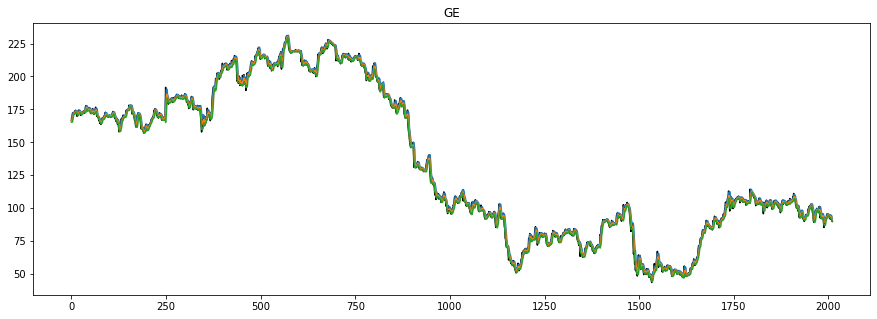

In [11]:
# Plot do gráfico
fig, ax = plt.subplots(1, 1, figsize=(15,5));

plt.title(ticker1)
ax.plot(modelBollinger.prices[-len(modelBollinger.indicator):], color='black');
ax.plot(modelBollinger.indicator);

In [12]:
modelBollinger = Bollinger()
print(evaluateHist(modelBollinger, {ticker2: f'{ticker2}.csv'}))

Number of trades: 520
Gross P&L: -3.16
Gross Accumulated return: -0.06%
Gross Average Return: -0.07%
Net P&L: -3.17
Hitting ratio: 56.92%



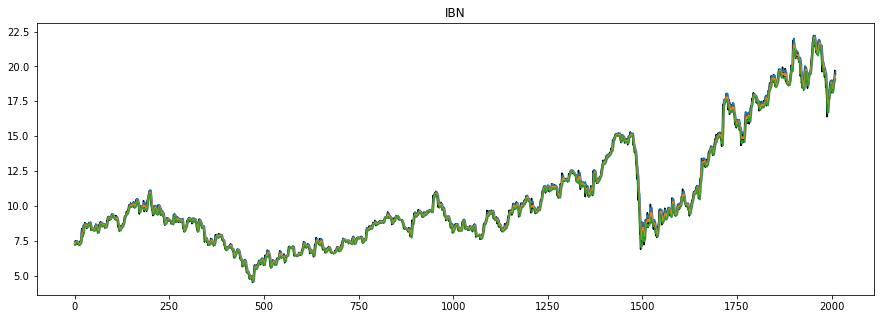

In [13]:
# Plot do gráfico
fig, ax = plt.subplots(1, 1, figsize=(15,5));

plt.title(ticker2)
ax.plot(modelBollinger.prices[-len(modelBollinger.indicator):], color='black');
ax.plot(modelBollinger.indicator);

In [14]:
modelBollinger = Bollinger()
print(evaluateHist(modelBollinger, {ticker3: f'{ticker3}.csv'}))

Number of trades: 534
Gross P&L: 2.69
Gross Accumulated return: 0.10%
Gross Average Return: 0.11%
Net P&L: 2.69
Hitting ratio: 60.86%



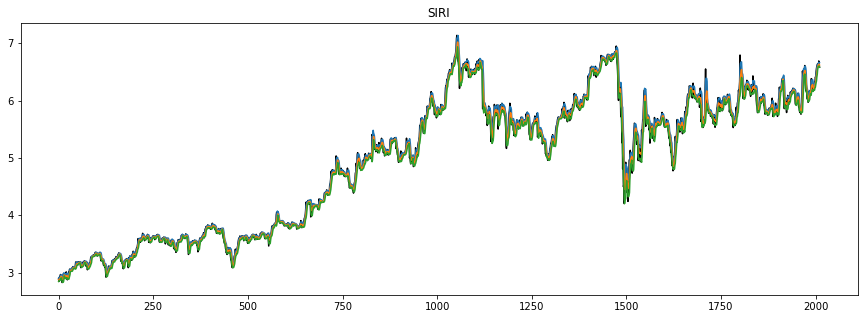

In [15]:
# Plot do gráfico
fig, ax = plt.subplots(1, 1, figsize=(15,5));

plt.title(ticker3)
ax.plot(modelBollinger.prices[-len(modelBollinger.indicator):], color='black');
ax.plot(modelBollinger.indicator);

In [16]:
help(ta.kst)

Help on function kst in module pandas_ta.momentum.kst:

kst(close, roc1=None, roc2=None, roc3=None, roc4=None, sma1=None, sma2=None, sma3=None, sma4=None, signal=None, drift=None, offset=None, **kwargs)
    'Know Sure Thing' (KST)
    
    The 'Know Sure Thing' is a momentum based oscillator and based on ROC.
    
    Sources:
        https://www.tradingview.com/wiki/Know_Sure_Thing_(KST)
        https://www.incrediblecharts.com/indicators/kst.php
    
    Calculation:
        Default Inputs:
            roc1=10, roc2=15, roc3=20, roc4=30,
            sma1=10, sma2=10, sma3=10, sma4=15, signal=9, drift=1
        ROC = Rate of Change
        SMA = Simple Moving Average
        rocsma1 = SMA(ROC(close, roc1), sma1)
        rocsma2 = SMA(ROC(close, roc2), sma2)
        rocsma3 = SMA(ROC(close, roc3), sma3)
        rocsma4 = SMA(ROC(close, roc4), sma4)
    
        KST = 100 * (rocsma1 + 2 * rocsma2 + 3 * rocsma3 + 4 * rocsma4)
        KST_Signal = SMA(KST, signal)
    
    Args:
        c

In [17]:
class KST(Strategy):
    
    def __init__(self):
        
        # Definir as quantidades de dias para cada taxa de variação
        self.x1 = 10 # Dias
        self.x2 = 15 # Dias
        self.x3 = 20 # Dias
        self.x4 = 30 # Dias
        
        # Definir cada intervalo de dias para as médias móveis simples
        self.avg1 = 10 # Dias
        self.avg2 = 10 # Dias
        self.avg3 = 10 # Dias
        self.avg4 = 15 # Dias
        
        # Período de 9 meses para calcular a média móvel simples de comparação
        self.period = 9 # Dias
        
        # Lista para guardar os preços e o indicador
        self.prices = []
        self.indicator = []
        
        # Side da estratégia (+1 Compra/-1 Vende)
        self.side = 0
        
    def push(self, event):
        
        orders = []
        
        price = event.price[3] # Captura o preço atual vindo do evento
        
        self.prices.append(price)
        
        if len(self.prices) > max(self.x1, self.x2, self.x3, self.x4,
                                  self.avg1, self.avg2, self.avg3, self.avg4,
                                  self.period):
            
            close = pd.DataFrame({'close': self.prices})
            
            kstdf = close.ta.kst(roc1=self.x1, roc2=self.x2, roc3=self.x3, roc4=self.x4,
                               sma1=self.avg1, sma2=self.avg2, sma3=self.avg3, sma4=self.avg4,
                               signal=self.period)
            
            kst        = kstdf.iloc[-1, 0]
            kst_before = kstdf.iloc[-2, 0]
            kst_signal = kstdf.iloc[-1, 1]
            
            # Guarda os dados para o gráfico
            self.indicator.append([kst, kst_signal])
            
            if kst_before < kst_signal:
                signal = 1
            elif kst_before > kst_signal:
                signal = -1
            else:
                signal = self.side
                
            # Ajustando posição
            if self.side != signal:
                orders.append(Order(event.instrument, -self.side, 0))
                orders.append(Order(event.instrument, signal, 0))
                self.side = signal
            
        return orders

In [18]:
modelKST = KST()
print(evaluateHist(modelKST, {ticker1: f'{ticker1}.csv'}))

Number of trades: 114
Gross P&L: -33.48
Gross Accumulated return: -0.22%
Gross Average Return: -0.19%
Net P&L: -33.50
Hitting ratio: 58.77%



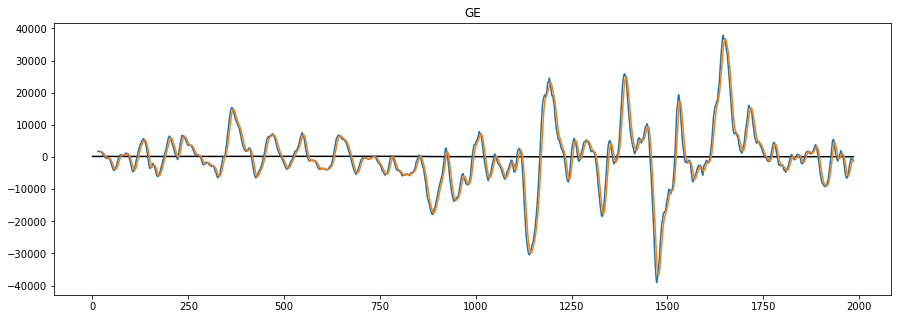

In [19]:
# Plot do gráfico
fig, ax = plt.subplots(1, 1, figsize=(15,5));

plt.title(ticker1)
ax.plot(modelKST.prices[-len(modelKST.indicator):], color='black');
ax.plot(modelKST.indicator);

In [20]:
modelKST = KST()
print(evaluateHist(modelKST, {ticker2: f'{ticker2}.csv'}))

Number of trades: 114
Gross P&L: -8.60
Gross Accumulated return: -0.72%
Gross Average Return: -0.40%
Net P&L: -8.61
Hitting ratio: 54.39%



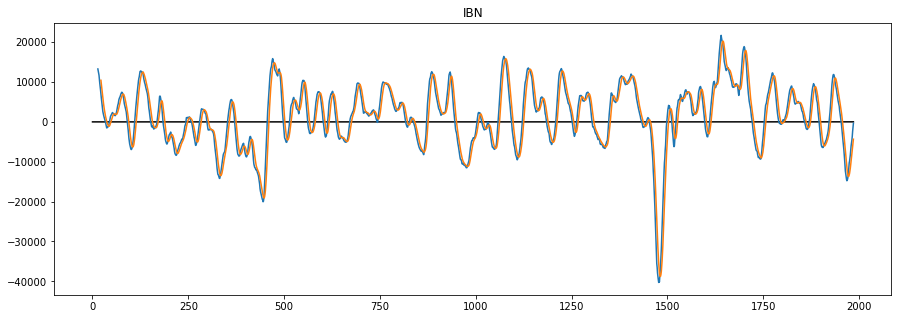

In [21]:
# Plot do gráfico
fig, ax = plt.subplots(1, 1, figsize=(15,5));

plt.title(ticker2)
ax.plot(modelKST.prices[-len(modelKST.indicator):], color='black');
ax.plot(modelKST.indicator);

In [22]:
modelKST = KST()
print(evaluateHist(modelKST, {ticker3: f'{ticker3}.csv'}))

Number of trades: 129
Gross P&L: 3.27
Gross Accumulated return: 0.50%
Gross Average Return: 0.39%
Net P&L: 3.27
Hitting ratio: 59.69%



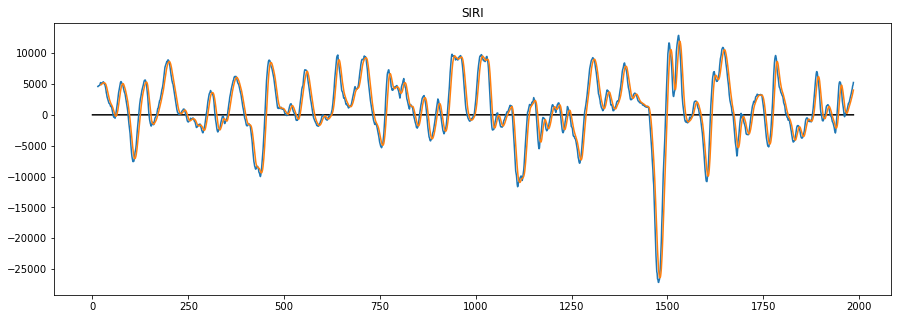

In [23]:
# Plot do gráfico
fig, ax = plt.subplots(1, 1, figsize=(15,5));

plt.title(ticker3)
ax.plot(modelKST.prices[-len(modelKST.indicator):], color='black');
ax.plot(modelKST.indicator);

In [24]:
help(ta.psar)

Help on function psar in module pandas_ta.trend.psar:

psar(high, low, close=None, af0=None, af=None, max_af=None, offset=None, **kwargs)
    Parabolic Stop and Reverse (psar)
    
    Parabolic Stop and Reverse (PSAR) was developed by J. Wells Wilder, that is used
    to determine trend direction and it's potential reversals in price. PSAR uses a
    trailing stop and reverse method called "SAR," or stop and reverse, to identify
    possible entries and exits. It is also known as SAR.
    
    PSAR indicator typically appears on a chart as a series of dots, either above or
    below an asset's price, depending on the direction the price is moving. A dot is
    placed below the price when it is trending upward, and above the price when it
    is trending downward.
    
    Sources:
        https://www.tradingview.com/pine-script-reference/#fun_sar
        https://www.sierrachart.com/index.php?page=doc/StudiesReference.php&ID=66&Name=Parabolic
    
    Calculation:
        Default Input

In [25]:
class PSAR(Strategy):
    
    def __init__(self):
        
        self.acc = 0.01 # Aceleração recomendada para ações = 0.01
        self.max_acc = 0.2 # Aceleração máxima recomendada = 0.2
        
        # Lista para guardar os preços high, low e close e o indicador
        # self.opens  = []
        self.highs  = []
        self.lows   = []
        self.closes = []
        
        self.prices = []
        
        self.indicator = []
        
        # Side da estratégia (+1 Compra/-1 Vende)
        self.side = 0
        
    def push(self, event):
        
        orders = []
        
        # open_ = event.price[0]
        high  = event.price[1]
        low   = event.price[2]
        close = event.price[3]
        
        # self.opens.append(open_)
        self.highs.append(high)
        self.lows.append(low)
        self.closes.append(close)
        
        price = event.price[3]
        
        self.prices.append(price)
        
        if len(self.closes) + len(self.highs) + len(self.lows) > 3:
            
            high = pd.Series(self.highs)
            low  = pd.Series(self.lows)
            close = pd.DataFrame({'close': self.closes})
            
            psardf = close.ta.psar(high=high, low=low, af=self.acc, af0=self.acc, max_af=self.max_acc)
            
            long = psardf.iloc[-1, 0]
            short = psardf.iloc[-1, 1]
            af = psardf.iloc[-1, 2]
            reversal = psardf.iloc[-1, 3]
            
            # Guarda os dados para o gráfico
            self.indicator.append([long, short])
            
            if reversal == 1:
                if np.isnan(long):
                    signal = 1
                elif np.isnan(short):
                    signal = -1
                else:
                    signal = self.side
            else:
                signal = self.side
            
            # Ajustando posição
            if self.side != signal:
                orders.append(Order(event.instrument, -self.side, 0))
                orders.append(Order(event.instrument, signal, 0))
                self.side = signal
        return orders

In [26]:
modelPSAR = PSAR()
print(evaluateHist(modelPSAR, {ticker1: f'{ticker1}.csv'}))

Number of trades: 107
Gross P&L: -110.76
Gross Accumulated return: -0.74%
Gross Average Return: -0.82%
Net P&L: -110.78
Hitting ratio: 58.88%



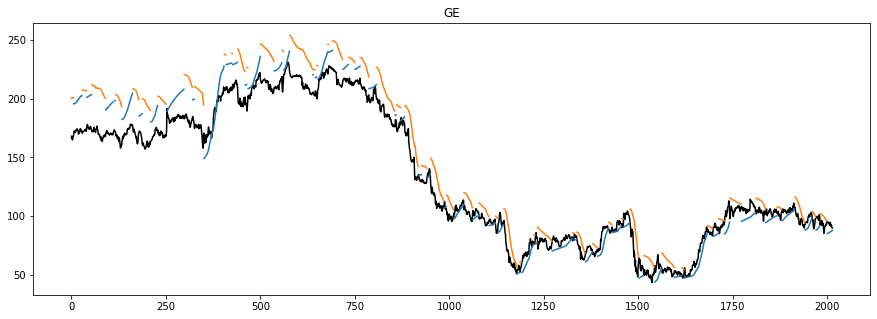

In [27]:
# Plot do gráfico
fig, ax = plt.subplots(1, 1, figsize=(15,5));

plt.title(ticker1)
ax.plot(modelPSAR.prices[-len(modelPSAR.indicator):], color='black');
ax.plot(modelPSAR.indicator);

In [28]:
modelPSAR = PSAR()
print(evaluateHist(modelPSAR, {ticker2: f'{ticker2}.csv'}))

Number of trades: 108
Gross P&L: 1.67
Gross Accumulated return: 0.14%
Gross Average Return: 0.58%
Net P&L: 1.67
Hitting ratio: 65.74%



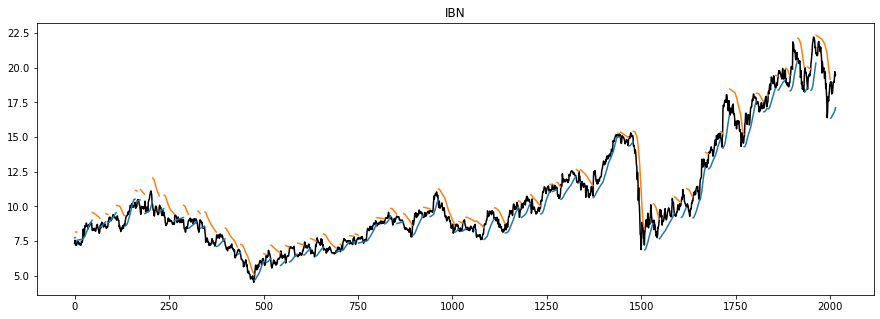

In [29]:
# Plot do gráfico
fig, ax = plt.subplots(1, 1, figsize=(15,5));

plt.title(ticker2)
ax.plot(modelPSAR.prices[-len(modelPSAR.indicator):], color='black');
ax.plot(modelPSAR.indicator);

In [30]:
modelPSAR = PSAR()
print(evaluateHist(modelPSAR, {ticker3: f'{ticker3}.csv'}))

Number of trades: 105
Gross P&L: 0.33
Gross Accumulated return: 0.06%
Gross Average Return: 0.08%
Net P&L: 0.32
Hitting ratio: 62.86%



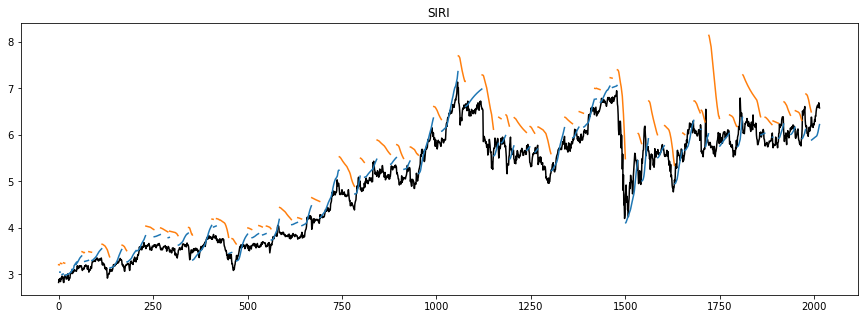

In [31]:
# Plot do gráfico
fig, ax = plt.subplots(1, 1, figsize=(15,5));

plt.title(ticker3)
ax.plot(modelPSAR.prices[-len(modelPSAR.indicator):], color='black');
ax.plot(modelPSAR.indicator);